In [ ]:
#install kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abhishekchaurasia24","key":"dcf27195d5988a2a2d5bc57b6299e0b7"}'}

In [ ]:
#CREATE A KAGGLE DIRECTORY
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d robinreni/signature-verification-dataset

 96% 576M/601M [00:03<00:00, 169MB/s]
100% 601M/601M [00:04<00:00, 154MB/s]


In [ ]:
!unzip signature-verification-dataset.zip

Archive:  signature-verification-dataset.zip
  inflating: sign_data/sign_data/test/049/01_049.png  
  inflating: sign_data/sign_data/test/049/02_049.png  
  inflating: sign_data/sign_data/test/049/03_049.png  
  inflating: sign_data/sign_data/test/049/04_049.png  
  inflating: sign_data/sign_data/test/049/05_049.png  
  inflating: sign_data/sign_data/test/049/06_049.png  
  inflating: sign_data/sign_data/test/049/07_049.png  
  inflating: sign_data/sign_data/test/049/08_049.png  
  inflating: sign_data/sign_data/test/049/09_049.png  
  inflating: sign_data/sign_data/test/049/10_049.png  
  inflating: sign_data/sign_data/test/049/11_049.png  
  inflating: sign_data/sign_data/test/049/12_049.png  
  inflating: sign_data/sign_data/test/049_forg/01_0114049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0206049.PNG  
  inflating: sign_data/sign_data/test/049_forg/01_0210049.PNG  
  inflating: sign_data/sign_data/test/049_forg/02_0114049.PNG  
  inflating: sign_data/sign_data/test/0

In [ ]:
train_dir="../content/sign_data/train"
test_dir="../content/sign_data/test_data"

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

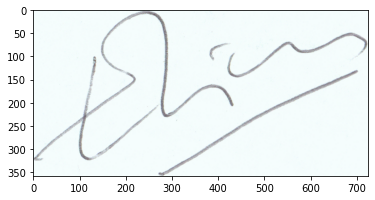

In [ ]:
import matplotlib.pyplot as plt
img = plt.imread('/content/sign_data/train/001/001_01.PNG')
plt.imshow(img)


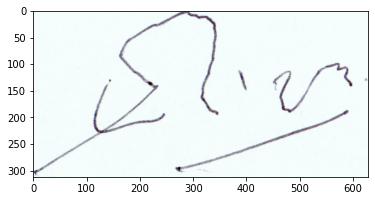

In [ ]:
img1 = plt.imread('/content/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img1)


In [ ]:
SIZE = 224

In [ ]:
import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir('/content/sign_data/train/'):
    for data in glob.glob('/content/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data

test_data = []
test_labels = []

for per in os.listdir('/content/sign_data/test/'):
    for data in glob.glob('/content/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)


In [ ]:
from keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [ ]:
train_data.shape

(1649, 1, 224, 224, 3)

In [ ]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

In [ ]:
train_data.shape

(1649, 224, 224, 3)

In [ ]:
train_labels.shape

(1649, 2)

In [ ]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

In [ ]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import Adam

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model.summary()

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
earlyStopping = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=3,
                              verbose=1)

early_stop=[earlyStopping]


EPOCHS = 20
BS = 64
progess = model.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)

Epoch 1/20
19/19 [==============================] - 72s 1s/step - loss: 0.8644 - accuracy: 0.4877 - val_loss: 0.7202 - val_accuracy: 0.5414
Epoch 2/20
19/19 [==============================] - 15s 792ms/step - loss: 0.6715 - accuracy: 0.6003 - val_loss: 0.7625 - val_accuracy: 0.5636
Epoch 3/20
19/19 [==============================] - 15s 795ms/step - loss: 0.5406 - accuracy: 0.7247 - val_loss: 0.2244 - val_accuracy: 0.9030
Epoch 4/20
19/19 [==============================] - 15s 801ms/step - loss: 0.1855 - accuracy: 0.9324 - val_loss: 0.1235 - val_accuracy: 0.9495
Epoch 5/20
19/19 [==============================] - 15s 809ms/step - loss: 0.1090 - accuracy: 0.9561 - val_loss: 0.4132 - val_accuracy: 0.8586
Epoch 6/20
19/19 [==============================] - 15s 817ms/step - loss: 0.1441 - accuracy: 0.9482 - val_loss: 0.1387 - val_accuracy: 0.9475
Epoch 7/20
19/19 [==============================] - 16s 825ms/step - loss: 0.0771 - accuracy: 0.9742 - val_loss: 0.0840 - val_accuracy: 0.9737
Ep

<Figure size 432x288 with 0 Axes>

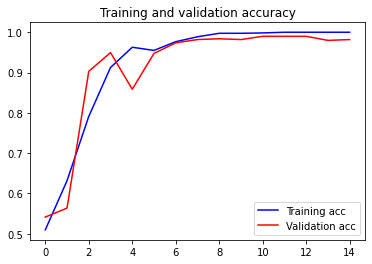

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = progess.history['accuracy']
val_acc = progess.history['val_accuracy']
loss = progess.history['loss']
val_loss = progess.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()

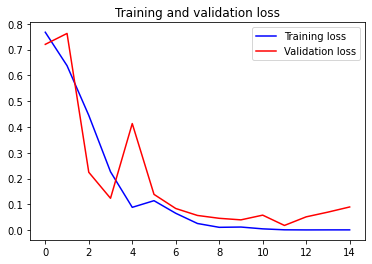

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [ ]:
pred = model.predict(test_data)



In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(pred,axis=1), test_labels)

1.0

In [ ]:
from sklearn.metrics import recall_score
recall_score(np.argmax(pred,axis=1), test_labels)

1.0

In [ ]:
from sklearn.metrics import precision_score
precision_score(np.argmax(pred,axis=1), test_labels)

1.0

In [ ]:

from sklearn.metrics import f1_score
f1_score(np.argmax(pred,axis=1), test_labels)

1.0